In [1]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_DIR =  '/content/drive/MyDrive/frotated_image/'
%cd {ROOT_DIR}

Mounted at /content/drive
/content/drive/MyDrive/frotated_image


In [15]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Desired image dimensions
image_size = (224, 224)

image_folder_path = '/content/drive/MyDrive/frotated_image/'

# List all images in the folder
image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Load and resize images, label as 'correct'
correct_images = []
for image_file in image_files:
    img_path = os.path.join(image_folder_path, image_file)
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, image_size)
    correct_images.append(resized_img)

# Combine and create the dataset
X = np.array(correct_images)
y = np.array([1] * len(correct_images))  # '1' for correct images

# Generate incorrect images by rotating
incorrect_images = []
for img in correct_images:
    angle = random.choice([90, 180, 270])
    rotated_img = cv2.rotate(img, {
        90: cv2.ROTATE_90_CLOCKWISE,
        180: cv2.ROTATE_180,
        270: cv2.ROTATE_90_COUNTERCLOCKWISE
    }[angle])
    incorrect_images.append(rotated_img)

X_incorrect = np.array(incorrect_images)
y_incorrect = np.array([0] * len(incorrect_images))  # '0' for incorrect images

# Combine correct and incorrect images
X = np.concatenate((X, X_incorrect), axis=0)
y = np.concatenate((y, y_incorrect), axis=0)


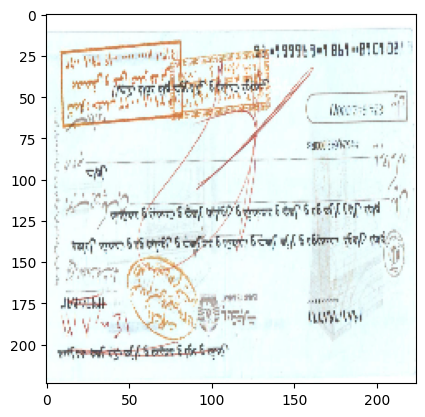

In [5]:
from matplotlib import pyplot as plt
plt.imshow(X[151])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation generator
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create generators for training and validation
train_generator = datagen.flow(X_train, y_train, batch_size=24)
val_generator = datagen.flow(X_val, y_val, batch_size=24)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential


# Modify your model-building functions to include L2 regularization
def build_mobilenet_model(input_shape):
    base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        Flatten(),
        Dense(100, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_vgg16_model(input_shape):
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        Flatten(),
        Dense(100, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])
    return model


input_shape = ( 224, 224 , 3)

mobilenet_model = build_mobilenet_model(input_shape)
vgg16_model = build_vgg16_model(input_shape)

# Compile models
mobilenet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train MobileNet model with early stopping
mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Save MobileNet model
mobilenet_model.save('/content/mobilenet_orientation_model.h5')

# Train VGG16 model with early stopping
vgg16_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Save VGG16 model
vgg16_model.save('/content/vgg16_orientation_model.h5')


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.7257 - loss: 3.9965 - val_accuracy: 0.5333 - val_loss: 28.3388
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.9648 - loss: 1.9423 - val_accuracy: 0.5333 - val_loss: 34.2200
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.9914 - loss: 1.7475 - val_accuracy: 0.5333 - val_loss: 36.4504
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 1.0000 - loss: 1.6572 - val_accuracy: 0.5333 - val_loss: 25.5944
Epoch 5/10
5/8 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 1.0000 - loss: 1.5957

In [ ]:
import os
import re
import pytesseract
from PIL import Image, ExifTags

def pytesseract_orientation_prediction(image_path):
    try:
        image = Image.open(image_path).convert("RGBA")

        # Handle DPI and EXIF orientation
        if image.info.get('dpi', (0, 0))[0] == 0:
            image.info['dpi'] = (300, 300)

        try:
            for orientation in ExifTags.TAGS.keys():
                if ExifTags.TAGS[orientation] == 'Orientation':
                    break
            exif = dict(image._getexif().items())
            if exif[orientation] == 3:
                image = image.rotate(180, expand=True)
            elif exif[orientation] == 6:
                image = image.rotate(270, expand=True)
            elif exif[orientation] == 8:
                image = image.rotate(90, expand=True)
        except (AttributeError, KeyError, IndexError):
            pass

        osd = pytesseract.image_to_osd(image)
        rotation = int(re.search('(?<=Rotate: )\d+', osd).group(0))

        return rotation
    except pytesseract.TesseractError as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobilenet

def load_vgg16_model():
    model = VGG16(weights='imagenet', include_top=False, input_shape=(512,512, 3))
    return model

def load_mobilenet_model():
    model = MobileNet(weights='imagenet', include_top=False, input_shape=(512,512, 3))
    return model

def predict_with_vgg16(model, img_path):
    img = image.load_img(img_path, target_size=(512,512))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_vgg(x)
    features = model.predict(x)
    # Your classifier for orientation
    # Example: np.argmax(features)
    return np.argmax(features)

def predict_with_mobilenet(model, img_path):
    img = image.load_img(img_path, target_size=(512,512))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_mobilenet(x)
    features = model.predict(x)
    # Your classifier for orientation
    # Example: np.argmax(features)
    return np.argmax(features)


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Placeholder for integrating with VGG16 and MobileNet models
class ModelWrapper:
    def __init__(self, model, predictor_func):
        self.model = model
        self.predictor_func = predictor_func

    def predict(self, img_path):
        return self.predictor_func(self.model, img_path)

# Instantiate the models
vgg16_model = load_vgg16_model()
mobilenet_model = load_mobilenet_model()

# Create wrapped models
vgg16_predictor = ModelWrapper(vgg16_model, predict_with_vgg16)
mobilenet_predictor = ModelWrapper(mobilenet_model, predict_with_mobilenet)

# Function to predict using the ensemble
def ensemble_predict(image_path):
    pytesseract_prediction = pytesseract_orientation_prediction(image_path)
    vgg16_prediction = vgg16_predictor.predict(image_path)
    mobilenet_prediction = mobilenet_predictor.predict(image_path)

    # Voting mechanism
    predictions = [pytesseract_prediction, vgg16_prediction, mobilenet_prediction]
    final_prediction = max(set(predictions), key=predictions.count)

    return final_prediction


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(test_images, test_labels):
    predictions = []
    for img_path in test_images:
        pred = ensemble_predict(img_path)
        predictions.append(pred)

    accuracy = accuracy_score(test_labels, predictions)
    print(f'Ensemble Model Accuracy: {accuracy * 100:.2f}%')
    return accuracy

# Example usage
test_images = ['path_to_image1.jpg', 'path_to_image2.jpg', ...]  # List of test image paths
test_labels = [0, 90, 180, 270, ...]  # Corresponding correct rotations

evaluate_model(test_images, test_labels)
